In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision
torch.random.manual_seed(42)
torch.cuda.manual_seed(42)
import pandas as pd
from tqdm import tqdm, trange
from torchvision.transforms import Compose, Resize, Normalize, CenterCrop
from torchvision.models import resnet50, ResNet50_Weights
from torch.utils.data import DataLoader
import torchvision
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
import json
import copy
# from new_dataset import CocoDataset

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(torch.cuda.is_available())
print(torch.cuda.get_device_properties(device = 'cuda:0'))

True
_CudaDeviceProperties(name='NVIDIA GeForce GTX 1050 Ti', major=6, minor=1, total_memory=4095MB, multi_processor_count=6)


In [3]:
image_captions_df = pd.read_parquet('F://coco/captions/image_captions_df_less_than_15.parquet')
with open('F:/coco/annotations/instances_train2014.json') as file:
    data = file.read()
    data = json.loads(data)
category_df = pd.DataFrame.from_records(data['categories'])
enum_super_categories = list(category_df['supercategory'].unique())
data_df = pd.DataFrame.from_records(data['annotations'])

data_df['category_name'] = data_df['category_id'].map(category_df.set_index('id')['name'])
data_df['super_category'] = data_df['category_id'].map(category_df.set_index('id')['supercategory'])
data_df['super_category_id'] = data_df['super_category'].apply(lambda x: enum_super_categories.index(x))
new_data_df = data_df.groupby(['image_id']).agg(list)
new_captions_df = pd.merge(left = image_captions_df, right = new_data_df, how='inner', on='image_id')

In [4]:
manual_transforms = Compose([
                            Resize(size = (448,448), antialias = True),
                            # CenterCrop(size=(448,448)),
#                             Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
def make_absolute(relative_tensor, cell_size):
    for i in range(relative_tensor.shape[0]):
            for j in range(relative_tensor.shape[1]):
                box = relative_tensor[i][j]

                if torch.sum(box).item()!=0:
                     x_cell, y_cell = i,j
                     start_cell_x, start_cell_y = i*cell_size, j*cell_size
                     box[1], box[2] = (box[1]*cell_size)+start_cell_x, (box[2]*cell_size)+start_cell_y

    return relative_tensor


In [5]:
class CocoDataset(Dataset):
    def __init__(self,data_df, is_train=False, is_val=False, is_test = False, val_percent=10, test_percent = 5, transforms = None):
        self.new_data_df = copy.deepcopy(data_df)
        self.transforms = transforms
        
        
        
        if is_val:
            self.data_df = self.new_data_df.sample(frac = float(val_percent/100), axis = 0, ignore_index = True)
        if is_test:
            self.data_df = self.new_data_df.sample(frac = float(test_percent/100), axis = 0, ignore_index = True)
        else:
            self.data_df = self.new_data_df.sample(frac = 1- (float(val_percent/100) + float(test_percent/100)), axis = 0, ignore_index = True)
            
    def __len__(self):
        return len(self.data_df)
    
    def transform_bbox(self,bboxes, spatial_size, final_size):
        width, height = spatial_size[0], spatial_size[1]
        # new_bbox = torch.zeros_like(bboxes)
        bboxes[...,0] = (bboxes[...,0]/spatial_size[1])*final_size[0]
        bboxes[...,1] = (bboxes[...,1]/spatial_size[0])*final_size[1]
        bboxes[...,2] = bboxes[...,2]*(final_size[1]/spatial_size[1])
        bboxes[...,3] = bboxes[...,3]*(final_size[0]/spatial_size[0])

        return bboxes
    
    def make_relative(self,target_tensor, cell_size, image_size):

        for i in range(target_tensor.shape[0]):
            for j in range(target_tensor.shape[1]):
                box = target_tensor[i][j]
                
                if torch.sum(box).item()!=0:
                    x_cell, y_cell = (box[1]/cell_size).to(torch.int32).item(), (box[2]/cell_size).to(torch.int32).item()
                    
                    start_cell_x, start_cell_y = x_cell*cell_size, y_cell*cell_size
                    
                    box[1], box[2] = (box[1]-start_cell_x)/cell_size, (box[2]-start_cell_y)/cell_size  
        return target_tensor


    def make_target_tensor(self,bboxes):
        target_tensor = torch.zeros(7,7,17)
        for box in bboxes:
            x_cell, y_cell = int(box[1]/64), int(box[2]/64)
    
            if target_tensor[x_cell][y_cell].sum() ==0:              
                # box[...,1:5] = torchvision.ops.box_convert(box[...,1:5], in_fmt = 'xywh', out_fmt='cxcywh')
                box[...,1:5] = box[...,1:5]/448.0
                target_tensor[x_cell][y_cell] = box
                
        return target_tensor
    
    def __getitem__(self, ndx):
        folder_path = 'F://coco/train2014/train2014/'
        
        row = self.data_df.iloc[ndx]
        file_name = row['file_name']
        bboxes = torch.tensor(row['bbox'])
        cat_id = torch.tensor(row['super_category_id'])
        cat_names = row['super_category']
        image_id = row['image_id']        
        
        # Get the image-data from file_name
        image_array = torchvision.io.read_image(folder_path + file_name)
        image_array = (image_array/255.0).to(torch.float32)
        
        
        if self.transforms != None: # If transfroms are specified then convert the image and the bounding box to correct_size
            # Get the initial_size of the image
            spatial_size = image_array.shape[1:]

            # Transform the image
            image_array = self.transforms(image_array).to(torch.float32)
            # Convert the image and the bounding boxes to their specific sizes
            final_size = image_array.shape[1:]

            # Now we will input the bboxes, initial_imgage_size and the final_image_size to convert the bounding boxes.
            bboxes = self.transform_bbox(bboxes, spatial_size=spatial_size, final_size=final_size)       
        
        
        # Convert the bounding boxes to the dimension format understoood by the image.
        # bboxes = torchvision.ops.box_convert(bboxes, in_fmt='xywh', out_fmt='xyxy')

        # After transforming the image we convert the individual bounding boxes, classes and confidence of object to target tensor
        # The format of the out tensor is [object_confidence, bounding_boxes, one-hot class labels]
        y = torch.full((len(bboxes),1), fill_value = 1)
        new = torch.cat((y,bboxes), axis = 1)
        x = F.one_hot(cat_id, num_classes = 12)
        out = torch.cat((new,x ), axis = 1)
        
        target_tensor = self.make_target_tensor(out)
        # print("The target tensor is:", end = '/')
        # print(target_tensor)
        # target_tensor = self.make_relative(target_tensor, image_size=image_array.shape[1], cell_size=64)
        # print("The relative tensor is:", end = '/')
        # print(target_tensor)
        
        # assert target_tensor.shape == (7,7,17)
        
        
        return image_array,target_tensor
        
    def get_data_image_id(self,image_id=None):
        """ This function returns an image by its id and the corresponding multiple labesl in a present/no_present binary format"""
        

        folder_path = 'F://coco/train2014/train2014/'

        if image_id == None:
            raise ValueError('Must provide IMAGE ID')
        
        else:
            row = self.data_df[self.data_df['image_id']==image_id]
            file_name = row['file_name'].values[0]
            bounding_boxes_list = row['bbox'].values[0]
            category_id_list = row['category_id'].values[0]
            category_names_list = row['category_name'].values[0]

#             captions_array = torch.tensor(row['shortest_idx_tokens'][0][0])

            # Get the image-data from file_name
            image_array = torchvision.io.read_image(folder_path + file_name)
            image_array = (image_array/255.0).to(torch.float64)
            if self.transforms != None:
                image_array = self.transforms(image_array).to(torch.float32)
                
            # After transforming the image now we set up the target tensor that will be outputted
            # After transforming the image now we set up the target tensor that will be outputted
            y = torch.full((len(category_id_list),1), fill_value = 1)
            new = torch.cat((y,bounding_boxes_list), axis = 1)
            x = F.one_hot(category_id_list, num_classes = 12)
            out = torch.cat((new,x), axis = 1)
            return image_array, out, category_names_list
        
            

In [6]:
# test_coco = CocoDataset(data_df=new_captions_df,is_test = True, transforms=manual_transforms, test_percent=0.08)
val_coco = CocoDataset(data_df=new_captions_df,is_val = True, transforms=manual_transforms, val_percent=90)
train_coco = CocoDataset(data_df=new_captions_df,is_val = True, transforms=manual_transforms)

# test_coco_dataloader = DataLoader(dataset=test_coco,shuffle=False, pin_memory=True,batch_size = 2, drop_last = True)
val_coco_dataloader = DataLoader(dataset=val_coco,shuffle = True, pin_memory=True,batch_size = 2, drop_last=True)
train_coco_dataloader = DataLoader(dataset = train_coco, shuffle = True, pin_memory=True,batch_size = 2, drop_last=True)

In [7]:
len(val_coco_dataloader), len(train_coco_dataloader)

(1568, 26658)

The image shape is : torch.Size([3, 448, 448])
The target_tensor shape is : torch.Size([7, 7, 17])
['kitchen(1.0)', 'kitchen(1.0)', 'kitchen(1.0)']


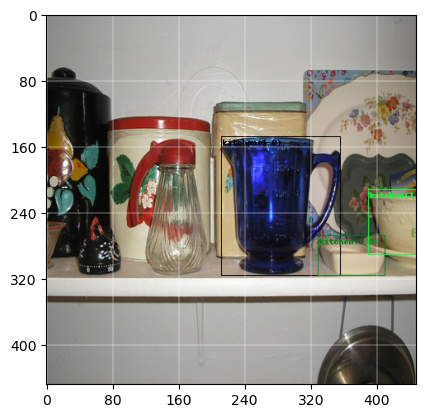

In [8]:
image,targets = train_coco[5]
print(f"The image shape is : {image.shape}")
print(f"The target_tensor shape is : {targets.shape}")

objects_list = []
class_names_list = []
class_conf_list = []
for target in targets:
    for box in target:
        if torch.sum(box)!=0:
            box[...,1:5] = torchvision.ops.box_convert(box[...,1:5], in_fmt='xywh', out_fmt='xyxy')
            objects_list.append(box)
            values, indices = torch.max(box[5:], dim=0)
            values = values.to(torch.device('cpu'))
            class_conf_list.append(str(torch.round(values, decimals=2).numpy()))
            class_names_list.append(enum_super_categories[indices.item()])


class_names_list = [y+"("+x+")" for x,y in zip(class_conf_list, class_names_list)]
print(class_names_list)
fig, ax = plt.subplots()
object_tensor = torch.stack(objects_list)  
plot_image = torchvision.utils.draw_bounding_boxes((image*255).to(torch.uint8), object_tensor[:,1:5]*448.0, labels=class_names_list)
ax.imshow(plot_image.permute(1,2,0).numpy())
ax.xaxis.set_major_locator(plt.MaxNLocator(7))  # Set the number of x-axis grid lines
ax.yaxis.set_major_locator(plt.MaxNLocator(7))  # Set the number of y-axis grid lines
ax.grid(visible=True,which='both', color = 'w', linestyle='-', linewidth=0.3)

In [ ]:
class Alexnet(nn.Module):
    def __init__(self):
        super(Alexnet,self).__init__()
        self.conv1 = nn.Conv2d(in_channels = 3, out_channels =96, kernel_size = 11, stride = 4, padding='valid')
        self.mp1 = nn.MaxPool2d(kernel_size=3, stride = 2)
        self.conv2 = nn.Conv2d(in_channels=96, out_channels=256, kernel_size=5,stride = 1, padding='same')
        self.mp2 = nn.MaxPool2d(kernel_size=3, stride=2)
        self.conv3 = nn.Conv2d(in_channels=256, out_channels=384, kernel_size = 3, stride = 1, padding='same')
        self.conv4 = nn.Conv2d(in_channels=384, out_channels=384, kernel_size=3, stride=1, padding='same')
        self.conv5 = nn.Conv2d(in_channels=384, out_channels=256, kernel_size=3, stride = 1, padding='same')
        self.mp3 = nn.MaxPool2d(kernel_size=3, stride = 2)
        self.fc1 = nn.Linear(in_features=36864, out_features=4096, bias=True)
        self.fc2 = nn.Linear(in_features=4096, out_features=4096, bias = True)
        self.fc3 = nn.Linear(in_features=4096, out_features = 1666, bias = True)

        
    def forward(self, x):
        out = F.relu(self.conv1(x)) 
        out = self.mp1(out)
        out = F.relu(self.conv2(out))
        out = self.mp2(out)
        out  = F.relu(self.conv3(out))
        out = F.relu(self.conv4(out))
        out = F.relu(self.conv5(out))
        out = self.mp3(out)
        out = torch.flatten(out, start_dim = 1)
        out = F.relu(self.fc1(out))
        out = F.relu(self.fc2(out))
        out = self.fc3(out)
        out = out.reshape(2,7,7,34)
        return out

In [ ]:
al_model = Alexnet().to(device = device)
for parameter in list(al_model.parameters())[:-1]:
    if parameter.ndim >= 2:
        nn.init.kaiming_normal_(parameter, mode='fan_in', nonlinearity='relu')

In [ ]:
optimizer = optim.Adam(al_model.parameters(), lr = 3e-6)
print(f"The number of parameters : {sum(p.numel() for p in al_model.parameters())}")

In [ ]:
for image, target in test_coco_dataloader:
    image = image.to(device = device)
    target = target.to(device)
    break

In [ ]:
for i in range(50):
    preds = al_model(image)

    loss = yolo_loss_single_one(preds, target)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    print(loss)

In [ ]:
preds = al_model(image)

In [9]:
def validation_loop(model, val_dataloader):
    with torch.no_grad():
        total_val_loss = 0
        for val_batch in tqdm(val_dataloader):
            val_image, val_targets = val_batch
            
            val_image = val_image.to(device)
            val_targets = val_targets.to(device)
            
            val_preds = model(val_image)
            
            val_loss = yolo_loss_single_one(val_preds, val_targets)
            total_val_loss+=val_loss
    total_val_loss = total_val_loss/len(val_coco_dataloader)
    return total_val_loss

In [10]:
def training_loop(epochs, model, train_dataloader, val_dataloader, optimizer):
    for epoch in range(epochs):
        # if (epoch%10==0) & (epoch!=0):
        if epoch!=0:
            torch.save(model.state_dict(),  'yolo__res50_model_state_dict.pt')
        epoch_loss = 0
        print("Training is progressing.....")
        for batch in tqdm(train_dataloader):
            # print(batch)
            image, targets = batch

            image = image.to(device)
            targets = targets.squeeze(0).to(device)
            # print(targets.shape)

            pred = model(image)
            # print(pred)

            optimizer.zero_grad()

            loss = yolo_loss_single_one(pred, targets)
            
            loss.backward()

            optimizer.step()
            epoch_loss += loss
        # Now we will get the validation loss
        # First we would set the model in the evaluation mode so that the batchnorm layers are not updated
        model.eval()
        
        # Next we will calculate the validation loss
        print("Validation is progressing.....")
        val_loss = validation_loop(model, val_dataloader)
        
        # Next we would again set the model in the training mode 
        model.train()
        print(f"Epoch : {epoch} | Train Loss : {epoch_loss/len(train_dataloader)} | Val Loss : {val_loss} ")

In [ ]:
training_loop(10, al_model, test_coco_dataloader, optimizer)

The below cell is for plotting the results of the bounding box predictions on the image

In [ ]:
torch.save(yolo_model.state_dict(),  'yolo_model_state_dict.pt')

In [ ]:
image0, target0 = test_coco[24]
image1, target1 = test_coco[25]
test_image = torch.stack([image0, image1]).to(device = device)
test_targets = torch.stack([image0, image1]).to(device = device)
print(test_image.shape)
print(test_targets.shape)

In [ ]:
with torch.no_grad():
    preds = res_model(test_image)
    print(preds.shape)

In [ ]:
new_image = test_image[1]
new_pred  = preds[1].clone().detach()
new_pred = new_pred.reshape(-1,17)
boxes = new_pred[...,1:5]
scores = new_pred[...,0]

# Now we would also have to get rid of the boxes which after conversion have x1>x2 or y1>y2
not_converted = 0
for box in new_pred:
    try:
        box[...,1:5] = torchvision.ops.box_convert(box[...,1:5], in_fmt = 'xywh', out_fmt='xyxy')
    except Exception as e:
        not_converted+=1

# Now we will need to find the nms of the bounding boxes of the images
nms = torchvision.ops.nms(boxes=boxes, scores=scores, iou_threshold=0.00001)
new_pred = new_pred[nms]
print(new_pred.shape)

# Now for each of the converted boxes we need to check which have x1<x2 and y1<y2
correct_boxes = []
class_names_list = []
class_conf_list = []
for box in new_pred:
    
    if (box[1]>=0.0000) & (box[2]>=0.0000) & (box[3]>=0.0000) & (box[4]>=0.0000):
        if (box[1]<box[3]) & (box[2]<box[4]):
            correct_boxes.append(box)
            values, indices = torch.max(box[5:], dim=0)
            values = values.to(torch.device('cpu'))
            class_conf_list.append(str(torch.round(values, decimals=2).numpy()))
            class_names_list.append(enum_super_categories[indices.item()])

correct_boxes = torch.stack(correct_boxes,dim=0)

class_names_list = [y+"("+x+")" for x,y in zip(class_conf_list, class_names_list)]
print(class_names_list)

# Plotting the image and the bounding boxes
fig, ax = plt.subplots()
object_tensor = torch.stack(objects_list)  
plot_image = torchvision.utils.draw_bounding_boxes((new_image*255).to(torch.uint8), correct_boxes[...,1:5]*448.0, labels=class_names_list)
ax.imshow(plot_image.permute(1,2,0).numpy())

ax.xaxis.set_major_locator(plt.MaxNLocator(7))  # Set the number of x-axis grid lines
ax.yaxis.set_major_locator(plt.MaxNLocator(7))  # Set the number of y-axis grid lines
ax.grid(visible=True,which='both', color = 'w', linestyle='-', linewidth=0.3)
    

In [11]:
def yolo_loss_single_one(preds, targets):
    full_loss = 0
    # print(preds.shape, targets.shape)
    for i in range(len(preds)):
        pred = preds[i]
        # print(pred.shape)  # shape would be (1,7,7,34)
        # For calculating the bounding boxes we will not have gradients on those tensors
        with torch.no_grad():
            # First find the IOU of each box in preds with the target box 
            box_1_iou = torchvision.ops.box_iou(boxes1 = pred[...,1:5].reshape(-1,4), boxes2 = targets[i][...,1:5].reshape(-1,4))
            # print(box_1_iou.shape)
            box_2_iou = torchvision.ops.box_iou(boxes1 = pred[...,18:22].reshape(-1,4), boxes2 = targets[i][...,1:5].reshape(-1,4))
            # print(box_2_iou.shape)

            # Now remove the IOU's which are not of the boxes in the same shell
            box_1_iou = torch.diagonal(box_1_iou)
            box_2_iou = torch.diagonal(box_2_iou)
            # print(box_1_iou.shape)
            # print(box_2_iou.shape)

            # Now stack the boxes IOU's to find the box with the higest IOU
            stack = torch.stack([box_1_iou, box_2_iou],dim = 1)
            # The find the best boxes of the stack
            values, indices = torch.max(stack,1)
        
        bbox_tensor = pred.reshape(-1,2,17)
        obj_tensor = targets[i][...,0]
        # print(obj_tensor.shape)
        # print(obj_tensor)


        noobj_tensor = 1-obj_tensor
        
        # print(noobj_tensor.shape)
        # print(noobj_tensor)
    
        best_box_tensor = bbox_tensor[torch.arange(bbox_tensor.shape[0]), indices]
        # print(best_box_tensor.shape)
        # print(best_box_tensor)

        best_box_tensor = best_box_tensor.reshape(-1,17)
        # print(best_box_tensor[...,0]*obj_tensor.reshape(-1))
        # print((best_box_tensor[...,0]*obj_tensor.reshape(-1)).shape)
        new_targets = targets[i].reshape(-1,17)
        # Now we have the best box tensors. we will calculate out losses
        
        confidence_obj_loss = F.mse_loss(best_box_tensor[...,0]*obj_tensor.reshape(-1), new_targets[...,0])#, reduction='sum')
        confidence_noobj_loss = F.mse_loss(best_box_tensor[...,0]*noobj_tensor.reshape(-1), new_targets[...,0])#,reduction='sum')

        total_confidence_loss = confidence_obj_loss + 0.5*confidence_noobj_loss
        # print(confidence_obj_loss, confidence_noobj_loss)
        # print(total_confidence_loss)
        
        # # Now calculate the bounding box loss
        x1_coord_loss =  F.mse_loss(best_box_tensor[:,1:2]*obj_tensor.reshape(-1,1), new_targets[...,1:2])#,reduction='sum')
        y1_coord_loss =  F.mse_loss(best_box_tensor[:,2:3]*obj_tensor.reshape(-1,1), new_targets[...,2:3])#,reduction='sum')
        x2_coord_loss =  F.mse_loss(best_box_tensor[:,3:4]*obj_tensor.reshape(-1,1), new_targets[...,3:4])#,reduction='sum')
        y2_coord_loss =  F.mse_loss(best_box_tensor[:,4:5]*obj_tensor.reshape(-1,1), new_targets[...,4:5])#,reduction='sum')

        # xy_coord_loss = F.mse_loss(best_box_tensor[...,1:3])
        
        # print(x1_coord_loss, y1_coord_loss, x2_coord_loss, y2_coord_loss)
        total_coord_loss=  5*(x1_coord_loss+y1_coord_loss+x2_coord_loss+y2_coord_loss)
        # print(total_coord_loss)
        
        # Next we will find the class probabilities loss
        # print(best_box_tensor[...,5:].shape)
        class_probs_pred = best_box_tensor[...,5:]*obj_tensor.reshape(-1,1)

        # print(best_box_tensor[...,5:])
        # print("break")
        # print(obj_tensor.reshape(-1,1))
        # print(class_probs_pred.shape)
        # print(class_probs_pred)
        # target_class_probs = targets[...,5:].reshape(batch_size*49,-1)
        target_class_probs = new_targets[...,5:]
    
        class_probs_loss = F.mse_loss(class_probs_pred, target_class_probs)#,reduction='sum')
        # print(class_probs_loss)

        total_loss = total_confidence_loss + total_coord_loss + class_probs_loss
        # print(total_loss)
        full_loss += total_loss
    # print(full_loss)
    return full_loss

In [ ]:
class YoloBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(YoloBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=in_channels, out_channels=in_channels//2, kernel_size=1, bias = True)
        # self.batchnorm1 = nn.BatchNorm2d(in_channels//2)
        self.conv2 = nn.Conv2d(in_channels=in_channels//2, out_channels=out_channels, kernel_size = 3, padding = 1, bias = True)
        # self.batchnorm2 = nn.BatchNorm2d(out_channels)

    def forward(self,x):
        out = self.conv1(x)
        out = F.leaky_relu(out)

        out = self.conv2(out)
        out = F.leaky_relu(out)
        return out
    
class Yolo(nn.Module):
    def __init__(self):

        super(Yolo,self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=7, stride=2, padding=3, bias=True)
        # self.batchnorm1 = nn.BatchNorm2d(64)
        self.maxpool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=192, kernel_size=3,padding=1, bias=True)
        # self.batchnorm2 = nn.BatchNorm2d(192)
        self.maxpool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.conv3 = nn.Conv2d(in_channels=192, out_channels=128, kernel_size=1, bias=True)
        # self.batchnorm3 = nn.BatchNorm2d(128)
        
        self.conv4 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1, bias=True)
        # self.batchnorm4 = nn.BatchNorm2d(256)
        
        self.conv5 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=1, bias=True)
        # self.batchnorm5 = nn.BatchNorm2d(256)
        
        self.conv6 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3,padding=1, bias=True)
        # self.batchnorm6 = nn.BatchNorm2d(512)
        self.maxpool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.conv7 = nn.Sequential(YoloBlock(512,512),
                                   YoloBlock(512,512),
                                   YoloBlock(512,512),
                                   YoloBlock(512,512))
        
        self.conv8 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=1, bias=True)
        # self.batchnorm8 = nn.BatchNorm2d(512)
        
        self.conv9 = nn.Conv2d(in_channels=512, out_channels=1024, kernel_size=3, padding=1, bias=True)
        # self.batchnorm9 = nn.BatchNorm2d(1024)
        self.maxpool4 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.conv10 = nn.Sequential(YoloBlock(1024,1024),
                                    YoloBlock(1024,1024),)
        
        self.conv11 = nn.Conv2d(in_channels = 1024, out_channels=1024, kernel_size=3, padding=1, bias=True)
        # self.batchnorm11 = nn.BatchNorm2d(1024)
        
        self.conv12 = nn.Conv2d(in_channels=1024, out_channels=1024,kernel_size=3, stride=2, padding=1, bias=True)
        # self.batchnorm12 = nn.BatchNorm2d(1024)
        
        self.conv13 = nn.Conv2d(in_channels=1024, out_channels=1024,kernel_size=3, padding=1, bias=True)
        # self.batchnorm13 = nn.BatchNorm2d(1024)
        
        self.conv14 = nn.Conv2d(in_channels=1024, out_channels=1024,kernel_size=3, padding=1, bias=True)
        # self.batchnorm14 = nn.BatchNorm2d(1024)

        self.linear1 = nn.Linear(in_features=50176, out_features=4096, bias=True)
        # self.b1 = nn.BatchNorm1d(4096)
        
        self.linear2 = nn.Linear(in_features=4096, out_features=1666, bias=True)
        # self.b2 = nn.BatchNorm1d(1666)
        
    def forward(self, x):
        out = F.relu(self.conv1(x))
        out = self.maxpool1(out)
        
        out = F.relu(self.conv2(out))
        out = self.maxpool2(out)
        
        out = F.relu(self.conv3(out))
        out = F.relu(self.conv4(out))
        out = F.relu(self.conv5(out))
        
        out = F.relu(self.conv6(out))
        out = self.maxpool3(out)

        out = self.conv7(out)
        out = F.relu(self.conv8(out))
        out = F.relu(self.conv9(out))
        out = self.maxpool4(out)
        out = self.conv10(out)
    
        out = F.relu(self.conv11(out))
        out = F.relu(self.conv12(out))
        out = F.relu(self.conv13(out))
        out = F.relu(self.conv14(out))
        out = torch.flatten(out,start_dim=1)
        # print(out.shape)
        out = F.relu(self.linear1(out))
        out = self.linear2(out)
        out = out.reshape(2,7,7,-1)
        return out

In [ ]:
yolo_model = Yolo().to(device = device)
yolo_model.load_state_dict(torch.load('yolo_model_state_dict.pt'))
# for parameter in list(yolo_model.parameters())[:-1]:
#     if parameter.ndim >= 2:
#         nn.init.kaiming_normal_(parameter, mode='fan_in', nonlinearity='relu')

In [ ]:
optimizer = optim.Adam(yolo_model.parameters(), lr = 3e-4)
print(f"The number of parameters : {sum(p.numel() for p in yolo_model.parameters())}")

In [ ]:
training_loop(40, yolo_model, test_coco_dataloader, optimizer)

In [ ]:
res_50 = resnet50(weights = ResNet50_Weights).to(device=device)

In [12]:
class yolo_res_50(nn.Module):

    def __init__(self):
        super(yolo_res_50,self).__init__()
        self.res_50 = resnet50(weights=ResNet50_Weights.DEFAULT)

        # for parameter in list(self.res_50.parameters()):
        #     parameter.requires_grad = False

        self.res_50.fc = nn.Linear(in_features=2048, out_features=4096)
        # self.b1 = nn.BatchNorm1d(4096)
        self.linear2 = nn.Linear(in_features=4096, out_features=1666)
        self.b2 = nn.BatchNorm2d(1666)

    def forward(self, x):
        out_backbone = self.res_50(x)
        # print(out_backbone.shape)
        # out = F.relu(self.b1(out_backbone))
        # out = F.relu(out_backbone
        # out = self.b2(self.linear2(out_backbone))
        out = self.linear2(out_backbone)
        out = out.reshape(2,7,7,34)
        # print(out.shape)
        return out

In [13]:
res_model = yolo_res_50().to(device = device)

In [14]:
optimizer = optim.Adam(res_model.parameters(), lr = 3e-4)
print(f"The number of parameters : {sum(p.numel() for p in res_model.parameters())}")

The number of parameters : 38729670


In [15]:
training_loop(5, res_model, train_coco_dataloader, val_coco_dataloader, optimizer)

Training is progressing.....


  4%|▍         | 1145/26658 [12:15<4:33:00,  1.56it/s]


KeyboardInterrupt: 